In [1]:
%matplotlib inline

In [8]:
from __future__ import division, print_function
import sys,os
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib

from imp import reload
import auxfilter
import matlabtools
import glob

In [10]:
os.chdir('..')
os.getcwd()

'/home/mike/venvs/ml/ml/py'

In [12]:
from eegkaggle import vectorizers

In [3]:
matplotlib.style.use('ggplot')

In [4]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slarge

Functions

Data loading section

In [9]:
basepath = '/home/mike/Downloads/train_1//'
basepathT = '/home/mike/Downloads/test_1/'
# path = basepath + '1_1_1.mat'
# rawdata = matlabtools.get_matlab_eeg_data(path)
# data = rawdata['data']
# print(data.shape)
# SR = rawdata['iEEGsamplingRate'][0][0]
# if SR == int(SR):
#     SR = int(SR)
# print(SR)

In [7]:
def vectorize_fft(path, ndim=800, # number of vector dimensions to output
                  cutoff=40, # hard cutoff frequency
                  fs=400, # sample frequency of input signal
                  takeLog=True, # take log of freq spectrum
                  avgChan=False, # take average across all channels
                  stdChan=False, # take stdDev across all channels - VERY INTERESTING
                  sepComplex=False, # prolly don't need this
                  hilbertize=False): # don't need this right now
    rawdata = matlabtools.get_matlab_eeg_data(path)['data']
    spectrum = ftpk.fft(rawdata, axis=0)
    nsamp0 = rawdata.shape[0]
    t = np.linspace(0, fs, nsamp0)
    cutIndex = cutoff*nsamp0/fs
#     plt.plot(t[:cutIndex],np.abs(spectrum[:cutIndex]))
#     plt.plot(t, spectrum)
    if avgChan:
        spectrum = np.mean(spectrum, axis=1)
    elif stdChan:
        spectrum = np.std(spectrum, axis=1)
    spectrum = np.abs(spectrum[:cutIndex])
    rs_spectrum = signal.resample(spectrum, ndim, axis=0)
    rs_t = np.linspace(0, cutoff, ndim)

#     print(rs_spectrum.shape)
#     print(np.angle(spectrum[:cutIndex]).shape)
#     plt.plot(t[:cutIndex], np.angle(spectrum[:cutIndex, 0]))
    """ Phase information at this point looks really nasty, so will ignore it"""

    if takeLog:
        rs_spectrum = np.log(rs_spectrum)
        
#     plt.plot(rs_t, rs_spectrum)
    return rs_spectrum

def spectrogram(path, nchunk=1024, 
                windowStep=4, # subdivide the chunk size in order to get a rolling window
                absLog=False,
                hardCutoff=100,
                fs=400
               ):
    rawdata = matlabtools.get_matlab_eeg_data(path)['data']
    nsamp0 = rawdata.shape[0]
    spec_ary = []
    cutIndex = hardCutoff*nchunk/fs

    step = nchunk//windowStep
    for i in range(0, nsamp0, step):
        spectrum = ftpk.fft(rawdata[i:i+nchunk], axis=0)[:cutIndex]
        if spectrum.shape[0] == cutIndex: # discard data that doesn't fit right because it messes up the array
            spec_ary.append(spectrum)
#             print(spectrum.shape)
    spec_ary = np.array(spec_ary)
    if absLog:
        spec_ary = np.log(np.abs(spec_ary))
    else:
        spect_ary = np.abs(spec_ary)

    return spec_ary

    


In [24]:
sources1 = glob.glob(basepath + '*_1.mat') 
sources0 = glob.glob(basepath + '*_0.mat') 
sourcesT = glob.glob(basepathT + '*.mat')
print(len(sources0), len(sources1), len(sourcesT))

1152 149 1584


In [ ]:
# plt.plot(vectorize_fft(sources0[0], avgChan=1))
# plt.plot(vectorize_fft(sources1[0], avgChan=1))

In [ ]:
# plt.plot(vectorize_fft(sources0[datanum], stdChan=1))
# plt.plot(vectorize_fft(sources1[datanum], stdChan=1))

Keras layer structure
option 1: take FFT, concat all the electrodes, feed into MLP (sigmoid). Dense 3 layer, 1-hot output. 
linearity bad. Reduce features (pca, smoothing, manual decimation) 
option 2: same, but with convo, max pooling instead of dimensionality reduction
option 3: noob feature vector maker (1600 per slice). feed into MLP as above.
option 4: NFV and use deep belief network (needs extensions)

In [ ]:
datanum = 9
print(sources0[datanum], sources1[datanum])

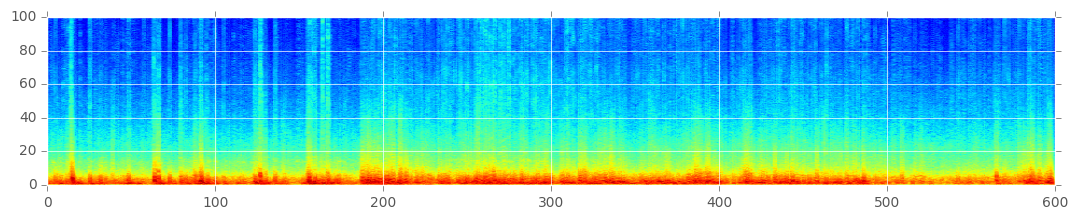

In [8]:
matplotlib.rcParams['figure.figsize'] = (13,2.4)
datanum = 1
gram0 = spectrogram(sources0[datanum], absLog=1)
gram1 = spectrogram(sources1[datanum], absLog=1)
grams = [gram0, gram1]

gram0.shape
ng = 0
for i in range(20):
#     plt.imshow(grams[ng][:,:,i].T, origin='lower', extent=[0, 600, 0, 100])
#     plt.savefig('../pics/gram_{}_{}_{:02d}.jpg'.format(datanum, ng,i))
    plt.imshow(np.average(grams[ng][:,:], axis=2).T, origin='lower', extent=[0, 600, 0, 100])
    plt.savefig('../pics/avg_e/agram_{}_{}.jpg'.format(datanum, ng))

In [9]:
datanum = 1


ng = 0
for datanum in range(1000):
    gram0 = spectrogram(sources0[datanum], absLog=1)
    gram1 = spectrogram(sources1[datanum], absLog=1)
    grams = [gram0, gram1]
    for ng in range(2):
        plt.imshow(np.average(grams[ng][:,:], axis=2).T, origin='lower', extent=[0, 600, 0, 100])
        plt.savefig('../pics/avg_e/agram_{}_{}.jpg'.format(datanum, ng))
        plt.close()

/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in log
/home/mike/venvs/ml/ml/local/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


IndexError: list index out of range

In [31]:
ng = 0
for datanum in range(1000):
    gramT = spectrogram(sources0[datanum], absLog=1)
    plt.imshow(np.average(gramT[:,:], axis=2).T, origin='lower', extent=[0, 600, 0, 100])
    plt.savefig('../pics/avg_e/tgram_{}.jpg'.format(datanum))
    plt.close()

/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in log
/home/mike/venvs/ml/ml/local/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in log


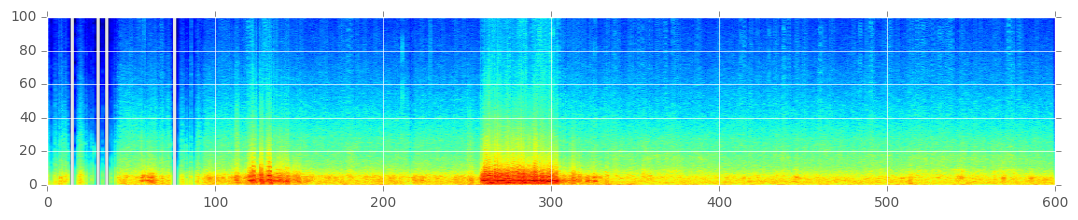

In [14]:
# What the fuck?, oh right, there is drop-out data
datanum=9
s1 = sources0[datanum]
s2 = sources1[datanum]
gram0 = spectrogram(sources0[datanum], absLog=1)
gram1 = spectrogram(sources1[datanum], absLog=1)
grams = [gram0, gram1]
plt.imshow(np.average(grams[0][:,:], axis=2).T, origin='lower', extent=[0, 600, 0, 100])


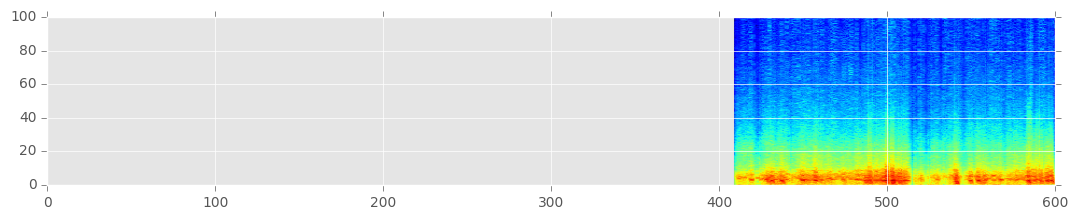

In [15]:
plt.imshow(np.average(grams[1][:,:], axis=2).T, origin='lower', extent=[0, 600, 0, 100])


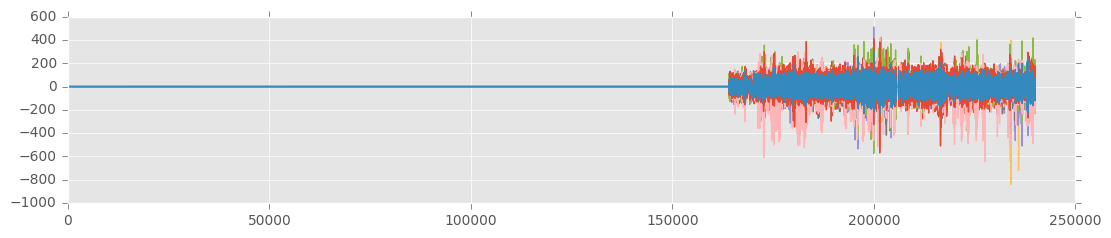

In [16]:
rawdata1 = matlabtools.get_matlab_eeg_data(sources1[datanum])['data']
plt.plot(rawdata1)

In [15]:
def validcount(path):
    rawdata1 = matlabtools.get_matlab_eeg_data(path)['data']
    return np.count_nonzero(rawdata1)/ np.size(rawdata1)
    

In [14]:
nchunk = 1024
droptest = []
for i in range(0, len(rawdata1), nchunk):
    stdval = np.std(rawdata1[i:i+nchunk], axis=0)
    
    droptest.append(np.average(stdval) )
    
plt.plot(droptest)
print(np.count_nonzero(rawdata1)/ np.size(rawdata1))

NameError: name 'rawdata1' is not defined

In [54]:
valids0 = []
valids1 = []
if 0: # long process
    for path in sources1:
        valids1.append([path, validcount(path)])
    #     print (path)

    for path in sources0:
        valids0.append([path, validcount(path)])
    #     print (path)

In [64]:
valids1
v0 = pd.DataFrame(np.asarray(valids0), columns=['path', 'validdata'])
v1 = pd.DataFrame(np.asarray(valids1), columns=['path', 'validdata'])

v0['label'] = 0
v1['label'] = 1
validdf = pd.merge(v0, v1, how='outer')
validdf['validdata'] = pd.to_numeric(validdf['validdata'])
validdf['pass95'] = validdf['validdata'] > .95
# valids

In [17]:
# validdf

In [66]:
validdf.to_csv('metadata/train1.csv')

In [68]:
np.average(validdf['pass95'])

0.73020753266717908

In [25]:
validsT = []
if 1: # long process
    for path in sourcesT:
        validsT.append([path, validcount(path)])
    #     print (path)


In [28]:
vT = pd.DataFrame(np.asarray(validsT), columns=['path', 'validdata'])
vT['validdata'] = pd.to_numeric(vT['validdata'])
vT['pass95'] = vT['validdata'] > .95

In [32]:
np.mean(vT['pass95'])

0.72348484848484851

In [37]:
np.mean(vT['validdata']> .5)

0.88131313131313127